# Tech Challenge FIAP – Otimização de Rotas Médicas (VRP com Algoritmo Genético)

Este notebook demonstra, de forma **fiel ao código do projeto**, a execução do Algoritmo Genético para otimização de rotas médicas (VRP) com **população semeada** a partir das rotas reais.

O fluxo geral é:
1. Garantir o ambiente (conda env `fiap_tsp`).
2. Executar o _script_ gerador de dados (`gerar_csv_entregas_rotas_iniciais.py`) – opcional se os CSVs já estiverem gerados.
3. Carregar `veiculos.csv`, `entregas.csv` e `rotas_iniciais.csv`.
4. Executar o GA VRP (`executar_ga_vrp`).
5. Analisar o histórico de fitness.
6. Explorar as rotas resultantes e gerar o mapa com o Folium.


In [1]:
# Configuração opcional para execução no Google Colab
import sys

if 'google.colab' in sys.modules:
    print('Detectado Google Colab: clonando repositório do projeto...')
    !git clone https://github.com/gustavopln/tech-challenge-fiap-otimizacao-rotas.git
else:
    print('Execução local: utilizando diretórios já existentes do projeto.')


Execução local: utilizando diretórios já existentes do projeto.


In [2]:
import sys
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

if 'google.colab' in sys.modules:
    # No Colab, o repositório foi clonado em /content
    PROJECT_ROOT = pathlib.Path('/content/tech-challenge-fiap-otimizacao-rotas').resolve()
else:
    # Execução local: sobe na hierarquia até encontrar a pasta src
    current_dir = pathlib.Path.cwd()
    PROJECT_ROOT = current_dir
    while not (PROJECT_ROOT / 'src').exists() and PROJECT_ROOT != PROJECT_ROOT.parent:
        PROJECT_ROOT = PROJECT_ROOT.parent
    if not (PROJECT_ROOT / 'src').exists():
        raise RuntimeError(
            f"Não foi possível localizar a pasta 'src' subindo a partir de {current_dir}"
        )

# Garante que o diretório raiz do projeto esteja no sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print('PROJECT_ROOT:', PROJECT_ROOT)
print('src exists? ', (PROJECT_ROOT / 'src').exists())
print('data exists?', (PROJECT_ROOT / 'data').exists())


PROJECT_ROOT: M:\Pessoal\FIAP\Fase 2 - Evolução da IA - GENAI - CLOUD ML e LLMs\06 - Tech Challenge\Projeto_2\tech-challenge-fiap-otimizacao-rotas
src exists?  True
data exists? True


## 1. Ambiente de execução

Este notebook assume que você está com o ambiente **conda** criado a partir do arquivo `environment.yml`:

```bash
conda env create -f environment.yml
conda activate fiap_tsp
```

E que o notebook está sendo executado **no diretório raiz do projeto**, onde existe a pasta `src/` e a pasta `data/`.


## 2. Imports do projeto

Aqui carregamos diretamente os módulos Python do projeto, mantendo a mesma estrutura utilizada no código-fonte (`src/core/medical_genetic_algorithm.py`, `src/models`, `src/visualization`).


In [3]:
from src.core.medical_genetic_algorithm import (
    carregar_veiculos_csv,
    carregar_entregas_csv,
    executar_ga_vrp,
    GAConfig,
)
from src.models.base_default import BASE_PADRAO
from src.models.models import Rota
from src.visualization.gerar_mapa_rotas_vrp import gerar_mapa_rotas_vrp

print('Base padrão:', BASE_PADRAO)


Base padrão: Base(nome='Almoxarifado Central da Secretaria de Saúde do DF', localizacao=(-15.8140447, -47.9659546))


## 3. (Opcional) Regenerar `entregas.csv` e `rotas_iniciais.csv`

Se você quiser **recriar** os arquivos `data/entregas.csv` e `data/rotas_iniciais.csv` a partir de
`data/hospitais_df.csv` e `data/veiculos.csv`, execute a célula abaixo.

Caso os arquivos já estejam corretos e atualizados, você pode pular esta etapa.


In [ ]:
# OPCIONAL: regenerar entregas.csv e rotas_iniciais.csv a partir de hospitais_df.csv
# Execute apenas se quiser refazer os CSVs.

%run src/utils/gerar_csv_entregas_rotas_iniciais.py


## 4. Inspecionar rapidamente os dados

Nesta etapa carregamos e conferimos:
- `data/hospitais_df.csv` – 100 hospitais e unidades de saúde, com latitude/longitude completas;
- `data/veiculos.csv` – parâmetros operacionais dos veículos;
- `data/entregas.csv` – entregas geradas a partir dos hospitais.


In [4]:
# Hospitais (fonte original)
hospitais_path = PROJECT_ROOT / 'data' / 'hospitais_df.csv'
df_hospitais = pd.read_csv(hospitais_path)
print('Total de hospitais:', len(df_hospitais))
df_hospitais.head()


Total de hospitais: 100


,IdHospital,Nome,Latitude,Longitude
0,1,Hospital de Base do Distrito Federal (IHBDF),-15.800672,-47.889162
1,2,Hospital Regional da Asa Norte (HRAN),-15.784717,-47.884175
2,3,Hospital Universitário de Brasília (HUB),-15.771302,-47.874363
3,4,Hospital Materno Infantil de Brasília (HMIB),-15.823818,-47.897529
4,5,Hospital Regional de Taguatinga (HRT),-15.822672,-48.069140


In [5]:
# Veículos
veiculos_path = PROJECT_ROOT / 'data' / 'veiculos.csv'
df_veiculos = pd.read_csv(veiculos_path)
print('Total de veículos:', len(df_veiculos))
df_veiculos.head()


Total de veículos: 10


,id_veiculo,capacidade_kg,autonomia_km,velocidade_media_kmh,custo_por_km
0,V1,1000,250,50,3.0
1,V2,850,400,60,2.5
2,V3,900,350,55,2.7
3,V4,450,550,65,2.0
4,V5,500,500,80,2.2


In [6]:
# Entregas geradas a partir dos hospitais
entregas_path = PROJECT_ROOT / 'data' / 'entregas.csv'
df_entregas = pd.read_csv(entregas_path)
print('Total de entregas:', len(df_entregas))
df_entregas.head()


Total de entregas: 100


,id,id_hospital,nome,lat,lng,prioridade,peso_kg,penalidade,tempo_estimado_entrega_min
0,1,1,Hospital de Base do Distrito Federal (IHBDF),-15.800672,-47.889162,BAIXA,48.96,1.0,15
1,2,2,Hospital Regional da Asa Norte (HRAN),-15.784717,-47.884175,ALTA,87.02,5.0,30
2,3,3,Hospital Universitário de Brasília (HUB),-15.771302,-47.874363,ALTA,43.24,5.0,30
3,4,4,Hospital Materno Infantil de Brasília (HMIB),-15.823818,-47.897529,MEDIA,69.61,2.0,10
4,5,5,Hospital Regional de Taguatinga (HRT),-15.822672,-48.069140,CRITICA,40.70,10.0,10


## 5. Carregar objetos de domínio e configurar o GA

Agora utilizamos diretamente as funções auxiliares do módulo `medical_genetic_algorithm` para construir as listas de `Veiculo` e `Entrega`, bem como a `BASE_PADRAO`.


In [7]:
from src.models.models import Entrega, Veiculo

base = BASE_PADRAO
entregas: list[Entrega] = carregar_entregas_csv(str(entregas_path))
veiculos: list[Veiculo] = carregar_veiculos_csv(str(veiculos_path))

print('Base logística:', base)
print('Qtde entregas:', len(entregas))
print('Qtde veículos:', len(veiculos))


Base logística: Base(nome='Almoxarifado Central da Secretaria de Saúde do DF', localizacao=(-15.8140447, -47.9659546))
Qtde entregas: 100
Qtde veículos: 10


### Configuração do Algoritmo Genético

A configuração abaixo reflete os parâmetros utilizados nos experimentos principais:

- `tamanho_populacao = 150`
- `geracoes = 1000`
- `taxa_mutacao = 0.25`
- `elitismo = 0.03`


In [8]:
config = GAConfig(
    tamanho_populacao=150,
    geracoes=1000,
    taxa_mutacao=0.25,
    elitismo=0.03,
)
config


GAConfig(tamanho_populacao=150, geracoes=1000, taxa_mutacao=0.25, elitismo=0.03)

## 6. Execução do GA VRP com população semeada

Aqui chamamos `executar_ga_vrp`, que:
- constrói a população inicial **semeada** a partir de `data/rotas_iniciais.csv`;
- evolui essa população ao longo das gerações;
- retorna as melhores rotas finais e o histórico do melhor fitness por geração.


In [9]:
rotas_resultado, historico_fitness = executar_ga_vrp(
    entregas=entregas,
    veiculos=veiculos,
    base=base,
    config=config,
    caminho_rotas_iniciais=str(PROJECT_ROOT / 'data' / 'rotas_iniciais.csv'),
)

In [10]:
# Encontrar geração com o melhor (menor) fitness
total_gen = len(historico_fitness)
melhor_gen_idx = min(range(len(historico_fitness)), key=lambda i: historico_fitness[i])
melhor_gen = melhor_gen_idx + 1  # ajusta para 1-based
melhor_valor = historico_fitness[melhor_gen_idx]
melhoria_absoluta = historico_fitness[0] - historico_fitness[-1]
melhoria_relativa_pct = (melhoria_absoluta / historico_fitness[0]) * 100 if historico_fitness[0] != 0 else 0.0

print(f"Total de gerações: {total_gen}")
print(f"Fitness inicial (geração 1)         : {historico_fitness[0]:.2f}")
print(f"Fitness final (geração {total_gen})        : {historico_fitness[-1]:.2f}")
print(f"Melhor fitness observado            : {melhor_valor:.2f}")
print(f"Geração do melhor fitness           : {melhor_gen}")
print(f"Melhoria absoluta (inicial - final) : {melhoria_absoluta:.2f}")
print(f"Melhoria relativa                   : {melhoria_relativa_pct:.2f}%")

Total de gerações: 1000
Fitness inicial (geração 1)         : 106042.42
Fitness final (geração 1000)        : 4452.06
Melhor fitness observado            : 4452.06
Geração do melhor fitness           : 643
Melhoria absoluta (inicial - final) : 101590.36
Melhoria relativa                   : 95.80%


## 7. Evolução do fitness ao longo das gerações

O gráfico abaixo mostra a evolução do **melhor fitness** em cada geração. Lembrando que, neste problema, **quanto menor o fitness, melhor a solução**.


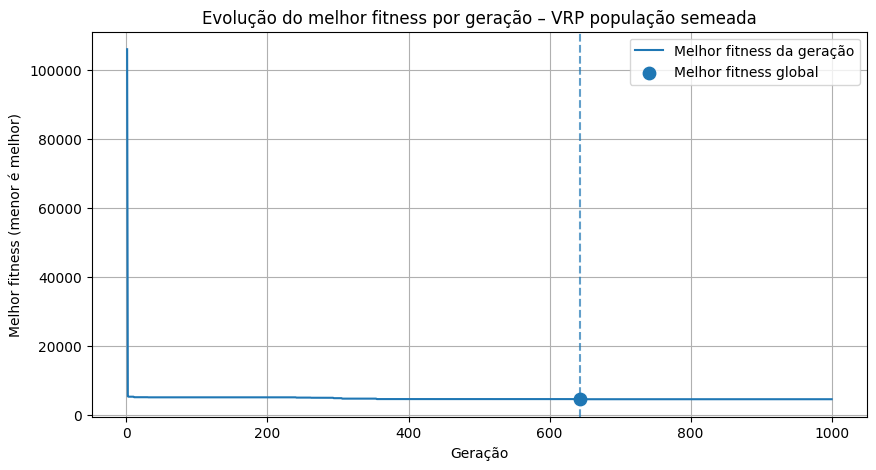

In [11]:
# Curva normal de melhor fitness por geração
geracoes = list(range(1, len(historico_fitness) + 1))

plt.figure(figsize=(10, 5))
plt.plot(geracoes, historico_fitness, label="Melhor fitness da geração")

# Marca o ponto da melhor geração global
plt.scatter([melhor_gen], [melhor_valor], s=80, marker="o", label="Melhor fitness global")

# Linha vertical na melhor geração
plt.axvline(melhor_gen, linestyle="--", alpha=0.7)

plt.xlabel("Geração")
plt.ylabel("Melhor fitness (menor é melhor)")
plt.title("Evolução do melhor fitness por geração – VRP população semeada")
plt.grid(True)
plt.legend()
plt.show()


## 8. Análise das rotas finais por veículo

Nesta seção, consolidamos as métricas principais de cada rota:
- distância total (km)
- carga total (kg)
- tempo total (min)
- custo total estimado (distância × custo_por_km + penalidade de prioridade)


In [12]:
import math
from src.models.models import Rota

dados_rotas = []
for rota in rotas_resultado:
    dados_rotas.append({
        'veiculo_id': rota.veiculo.id_veiculo,
        'distancia_km': rota.distancia_total_km,
        'carga_kg': rota.carga_total_kg,
        'tempo_min': rota.tempo_total_min,
        'custo_total': rota.custo_total(),
        'qtd_entregas': len(rota.entregas),
        'rota_valida': rota.is_valida(),
    })

df_rotas_resultado = pd.DataFrame(dados_rotas)
df_rotas_resultado


,veiculo_id,distancia_km,carga_kg,tempo_min,custo_total,qtd_entregas,rota_valida
0,V1,89.449632,278.73,352.339558,291.348896,6,True
1,V2,164.604810,835.14,619.604810,495.512026,15,True
2,V3,239.633607,520.18,591.418481,686.010740,10,True
3,V4,225.096144,328.13,512.781056,479.192288,9,True
4,V5,133.486294,463.47,325.114720,345.669846,9,True
5,V6,236.510791,611.94,664.208633,607.625898,12,True
6,V7,153.671372,544.60,487.641497,462.279842,9,True
7,V8,141.559345,651.37,386.559345,421.054297,11,True
8,V9,97.260684,537.12,507.260684,304.603848,10,True
9,V10,112.332831,432.83,332.544906,358.765209,9,True


## 9. Geração e visualização do mapa das rotas (Folium)

Por fim, geramos o mapa HTML com as rotas VRP utilizando a função `gerar_mapa_rotas_vrp`. Cada veículo aparece em uma camada própria, permitindo ativar/desativar a visualização de forma interativa.


In [ ]:
import sys
from IPython.display import display

# Caminho absoluto do arquivo de saída
mapa_path = PROJECT_ROOT / 'data' / 'resultados' / 'mapa_rotas_vrp.html'

# Gera o mapa e obtém o objeto folium.Map
mapa_final = gerar_mapa_rotas_vrp(
    rotas_resultado,
    nome_arquivo=str(mapa_path),
    salvar_arquivo=True, # se quiser manter o HTML salvo
)

mapa_final




Mapa das rotas VRP gerado em: M:\Pessoal\FIAP\Fase 2 - Evolução da IA - GENAI - CLOUD ML e LLMs\06 - Tech Challenge\Projeto_2\tech-challenge-fiap-otimizacao-rotas\data\resultados\mapa_rotas_vrp.html
Ative/desative as rotas dos veículos na legenda do mapa.


## 10. Conclusões

- O notebook reutiliza **exatamente** as funções e modelos definidos no projeto (`src/core`, `src/models`, `src/utils`, `src/visualization`).
- Os dados de entrada (hospitais, veículos, entregas, rotas iniciais) são os mesmos empregados no código final.
- A execução do GA com população semeada permite comparar a solução original (rotas_iniciais) com a solução evoluída.

Este material pode ser utilizado diretamente na apresentação da FIAP, tanto para demonstração ao vivo quanto para geração de prints e figuras para o relatório técnico.
